# Check Energy Conservation when Simulating with Flows

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

## Read Model

In [3]:
checkpoints = {
    "example": "example_checkpoint.ckpt",
    "smooth": ..,
    "smooth_nll": ...,
    "smooth_inverse": ...,
    "spline": ...,
    "affine": ...
}

MODEL = "example"
CHECKPOINT = checkpoints[MODEL]


In [4]:

from ala2flow import Ala2Generator

loaded = Ala2Generator.load_from_checkpoint(
    CHECKPOINT
)

Using downloaded and verified file: /tmp/A.pdb


/srv/public/kraemea88/coding/bgflow/bgflow/distribution/energy/openmm.py:215: UserWarning: It looks like you are using an OpenMMBridge with multiple workers in an ipython environment. This can behave a bit silly upon KeyboardInterrupt (e.g., kill the stdout stream). If you experience any issues, consider initializing the bridge with n_workers=1 in ipython/jupyter.
  warnings.warn(


## Read Dataset

In [5]:
from ala2flow import Ala2Data
data = Ala2Data(batch_size=128, slice=1)
data.prepare_data()
data.setup()

Using downloaded and verified file: /tmp/A.pdb
Using downloaded and verified file: /tmp/A.pdb


### Extract Masses and Initial Positions

In [6]:
from simtk.unit import amu
masses = []

for atom in data.dataset.system.topology.atoms():
    masses.append(atom.element.mass.value_in_unit(amu))

masses = torch.tensor(masses)

In [7]:
x0=torch.tensor(data.dataset.xyz[:10])
x0.shape, masses.shape
# flow_potential.force(x0)

(torch.Size([10, 22, 3]), torch.Size([22]))

## Define Model as the Potential for the Simulation

In [8]:
from ala2flow import FlowPotentialWrapper
potential = FlowPotentialWrapper(loaded.model, data.dataset.temperature)

In [9]:
# -- uncomment this to simulate with the ground truth potential instead --
#potential = FlowPotentialWrapper(
#    data.dataset.system.energy_model, 
#    data.dataset.temperature
#)


## NVT Equilibration

In [10]:
from ala2flow import VerletIntegrator, Simulation, LangevinIntegrator
nvt_integrator = LangevinIntegrator(potential, 0.001, masses=masses, temperature=300.)
nvt_simulation = Simulation(
    potential,
    nvt_integrator,
    x0=torch.tensor(data.dataset.xyz[:10]),
    temperature=data.dataset.temperature
)

In [11]:
from tqdm.auto import tqdm
nvt_simulation.step(1000, progress_bar=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

## NVE Simulation

In [12]:
nve_integrator = VerletIntegrator(potential, 0.001, masses=masses)
nve_simulation = Simulation(
    potential, 
    nve_integrator,
    x0=nvt_simulation.x,
    v0=nvt_simulation.v
)

In [13]:
nve_simulation.step(10000, progress_bar=tqdm)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
nve_simulation.integrator.time_step

0.001

In [15]:
from matplotlib import pyplot as plt
import numpy as np

Text(0, 0.5, 'Total Energy [kJ/mol]')

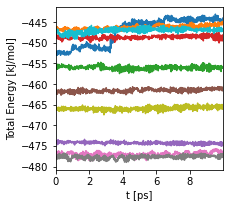

In [16]:
fig, ax = plt.subplots(figsize=(3,3))

energies = np.array(nve_simulation.energies)
dt = nve_simulation.report_interval * nve_simulation.integrator.time_step
times = np.arange(len(energies))*dt
ax.plot(times, energies[:,2,:])
ax.set_xlim(0.0, times[-1])
ax.set_xlabel("t [ps]")
ax.set_ylabel("Total Energy [kJ/mol]")

In [17]:
np.save(f"energies_{MODEL}.npy", energies)